<a href="https://colab.research.google.com/github/Siddharth0317/osl/blob/main/Exp_4_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

# Display plots inline
%matplotlib inline


In [ ]:

from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    print(filename)


In [ ]:
df = pd.read_csv("GOOG.csv")
df.head()

In [ ]:
# Extract only 'Date' and 'Close' columns
df = df[['Date', 'Close']]

# Check info
df.info()

# Show date range
print(df['Date'].min(), df['Date'].max())


In [ ]:
# Split the data into train and test sets
train = df.loc[df['Date'] <= '2017-12-24']
test  = df.loc[df['Date'] >  '2017-12-24']

train.shape, test.shape


((3360, 2), (760, 2))

In [ ]:
# Scale 'Close' column using StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1, 1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1, 1))
test['Close']  = scaler.transform(np.array(test['Close']).reshape(-1, 1))

# Visualize scaled training data
plt.plot(train['Close'], label='Scaled Close Prices')
plt.legend()
plt.show()


In [ ]:
TIME_STEPS = 30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X) - time_steps):
        X_out.append(X.iloc[i:(i + time_steps)].values)
        y_out.append(y.iloc[i + time_steps])
    return np.array(X_out), np.array(y_out)

# Create training and testing sequences
X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test   = create_sequences(test[['Close']], test['Close'])

print("Training input shape:", X_train.shape)
print("Testing input shape:", X_test.shape)


Training input shape: (3330, 30, 1)
Testing input shape: (730, 30, 1)


In [ ]:
# Set seed for reproducibility
np.random.seed(21)
tf.random.set_seed(21)

# Build model
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    RepeatVector(X_train.shape[1]),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(X_train.shape[2]))
])

# Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Model summary
model.summary()


In [ ]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
    shuffle=False
)

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step


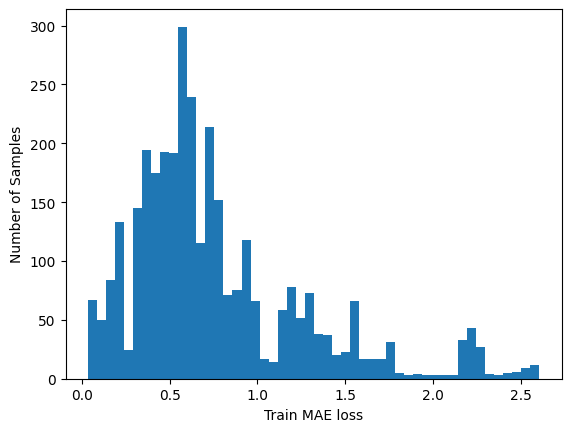

Reconstruction error threshold: 2.605561192152309


In [ ]:
# Predict on training data
X_train_pred = model.predict(X_train)

# Calculate MAE loss
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Visualize loss distribution
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)
print('Reconstruction error threshold:', threshold)


In [ ]:
# Predict on test data
X_test_pred = model.predict(X_test, verbose=1)

# Calculate test MAE loss
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Plot test loss distribution
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples')
plt.show()


In [ ]:
# Create anomaly dataframe
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

# Extract anomalies
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()


In [ ]:
# Plot actual close prices and anomalies
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=anomaly_df['Date'],
    y=scaler.inverse_transform(anomaly_df[['Close']]),
    name='Close Price'
))
fig.add_trace(go.Scatter(
    x=anomalies['Date'],
    y=scaler.inverse_transform(anomalies[['Close']]),
    mode='markers',
    name='Anomaly'
))
fig.update_layout(showlegend=True, title='Detected Anomalies in Google Stock Price')
fig.show()
